In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# Combining networks and check integrity

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel, model
import geopandas as gpd
if manual:
    %matplotlib inline

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'
plot_path = training_folder + 'outputs/plot/'

# Read PT network from model

In [4]:
sm = stepmodel.read_zippedpickles(training_folder + 'models/base/base')

zones: 100%|██████████| 9/9 [00:00<00:00, 41.86it/s]


In [5]:
sm.nodes.index = sm.nodes['stop_id']

# Road network

In [6]:
road_links = gpd.read_file(input_folder+'road/road_links.geojson', driver='GeoJSON')
road_nodes = gpd.read_file(input_folder+'road/road_nodes.geojson', driver='GeoJSON')
road_nodes.set_index('index', inplace=True)
sm.road_links = road_links
sm.road_nodes = road_nodes

In [7]:
road_links.head()

,index,a,b,length,geometry
0,3,125730,244455548,105.925,"LINESTRING (2.41073 48.86352, 2.41092 48.86258)"
1,5,125742,60912980,129.019,"LINESTRING (2.40137 48.85185, 2.40078 48.85294)"
2,8,125743,244455500,38.764,"LINESTRING (2.41341 48.85456, 2.41305 48.85431)"
3,9,125745,25245021,268.796,"LINESTRING (2.41435 48.85452, 2.41422 48.85694)"
4,10,125745,125743,73.156,"LINESTRING (2.41435 48.85452, 2.41341 48.85456)"


# road integrity

In [8]:
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [9]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 9714it [00:01, 7008.76it/s]
reversed: 9714it [00:01, 7460.80it/s]
9714it [00:01, 7353.52it/s]


In [10]:
sm.integrity_fix_nodeset_consistency()

## road_test

In [11]:
sm.integrity_test_dead_ends()

9714it [00:00, 30356.14it/s]


In [12]:
sm.integrity_test_isolated_roads()

In [13]:
sm.integrity_test_road_duplicated_ab_links()

# Transport Integrity

## transport_fix

In [14]:
sm.integrity_fix_collision()

In [15]:
sm.integrity_fix_circular_lines()

In [16]:
sm.integrity_fix_sequences()

In [17]:
sm.integrity_fix_nodeset_consistency()

## transport_test

In [18]:
sm.integrity_test_circular_lines()
sm.integrity_test_collision()
sm.integrity_test_nodeset_consistency()
sm.integrity_test_sequences()

In [19]:
sm.integrity_test_all(errors='ignore')

passed: integrity_test_circular_lines
passed: integrity_test_collision


9714it [00:00, 30074.29it/s]


passed: integrity_test_dead_ends
passed: integrity_test_duplicate_volumes
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency
passed: integrity_test_road_duplicated_ab_links


9714it [00:01, 7218.69it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences
passed: integrity_test_str_collision


In [20]:
sm = sm.change_epsg(epsg=3857, coordinates_unit='meter')

Reprojecting model from epsg 4326 to epsg 3857:   0%|          | 0/17 [00:00<?, ?it/s]

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████| 17/17 [00:01<00:00,  8.76it/s]


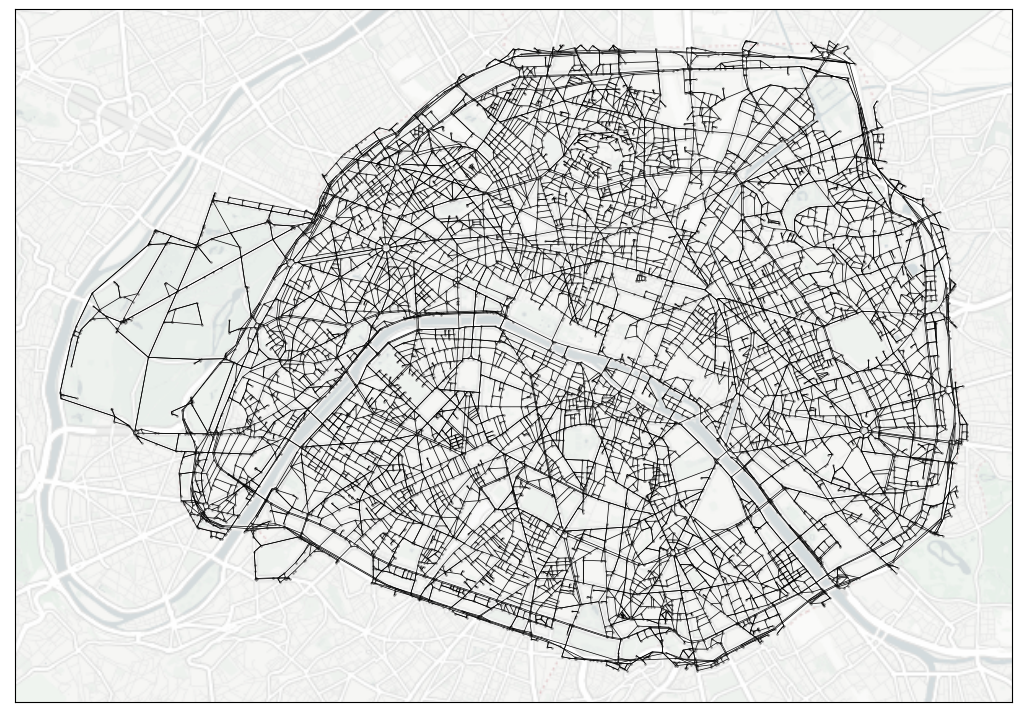

In [21]:
if manual:
    # pip install contextily required
    sm.plot(
        'road_nodes', color='grey', markersize=0.5,
        ax=sm.plot(
            'road_links', figsize=[16, 9], linewidth=0.5, color='black',
            basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
        ),    
    )

# to_zip

In [22]:
sm.to_zippedpickles(training_folder + 'models/base/networks')   

  0%|          | 0/17 [00:00<?, ?it/s]

orphan_nodes: 100%|██████████| 17/17 [00:00<00:00, 22.97it/s]


# END